# 🔧  Modeling & Forecasting Hourly Electricity Demand (ISO-NE)

This notebook builds and evaluates forecasting models for **hourly electricity demand** in the ISO-NE region. Accurate short-term forecasting directly supports:

✅ Grid stability  
✅ Efficient generation scheduling  
✅ Lower market price volatility  
✅ Reduced risk of outages/over-commitment  

We extend the cleaned dataset from Notebook `01_data_prep` and focus on **practical, operator-aligned forecasting**.


## 🎯 Objectives

- Establish meaningful **baseline** forecast performance
- Train a **regularized regression** forecasting model using lag features
- Use **time-based** validation to prevent leakage
- Report accuracy only on **true observed** demand (not imputed values)
- Produce **operational metrics** used by utilities/system operators


In [1]:
# 02_modeling — EDA, Baselines, and First Models (Test start: 2024-07-01)

# Reproducibility + versions
import platform, sys
import numpy as np, pandas as pd, sklearn
print("Python:", sys.version.split()[0], "| OS:", platform.system(), platform.release())
print("numpy:", np.__version__, "| pandas:", pd.__version__, "| scikit-learn:", sklearn.__version__)

import warnings, sys
warnings.filterwarnings("ignore")

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("pandas:", pd.__version__)


Python: 3.11.13 | OS: Darwin 24.6.0
numpy: 1.26.4 | pandas: 2.3.3 | scikit-learn: 1.3.2
Python: 3.11.13
NumPy: 1.26.4
pandas: 2.3.3


## 📦 Dataset Summary

Input data comes from ISO-NE hourly system load:

| Column | Description |
|--------|-------------|
| `demand_mw` | Hourly electricity demand in MW |
| `is_imputed` | Flag marking synthetic values inserted during cleaning |

> To ensure accuracy is **not inflated**, evaluation uses **only rows where `is_imputed == False`**.


In [2]:
# --- Load cleaned data ---
data = pd.read_csv("../data/processed/isone_demand_clean.csv", parse_dates=["datetime"])
data = data.set_index("datetime").sort_index()

print("Data range:", data.index.min(), "→", data.index.max())
print("Total hours:", len(data))
data.head(2)


Data range: 2021-02-11 16:00:00 → 2025-06-23 19:00:00
Total hours: 38236


,demand_mw,is_imputed,impute_method
datetime,,,
2021-02-11 16:00:00,15464.335,False,original
2021-02-11 17:00:00,16176.375,False,original


## 🧪 Train/Test Split — Real-World Aligned

**Training:** February 2021 → June 2024  
**Testing:** July 2024 → June 2025  

Why this split?

- Maintains multiple seasonal cycles
- Includes **high-risk operational periods** (e.g., heat waves, winter cold snaps)
- Prevents the model from seeing future conditions (**no leakage**)

We also construct a boolean **mask** to exclude imputed test rows from scoring.


Train: 2021-02-11 16:00:00 → 2024-07-01 23:00:00  (29,672 hours)
Test:  2024-07-01 00:00:00 → 2025-06-23 19:00:00  (8,588 hours)


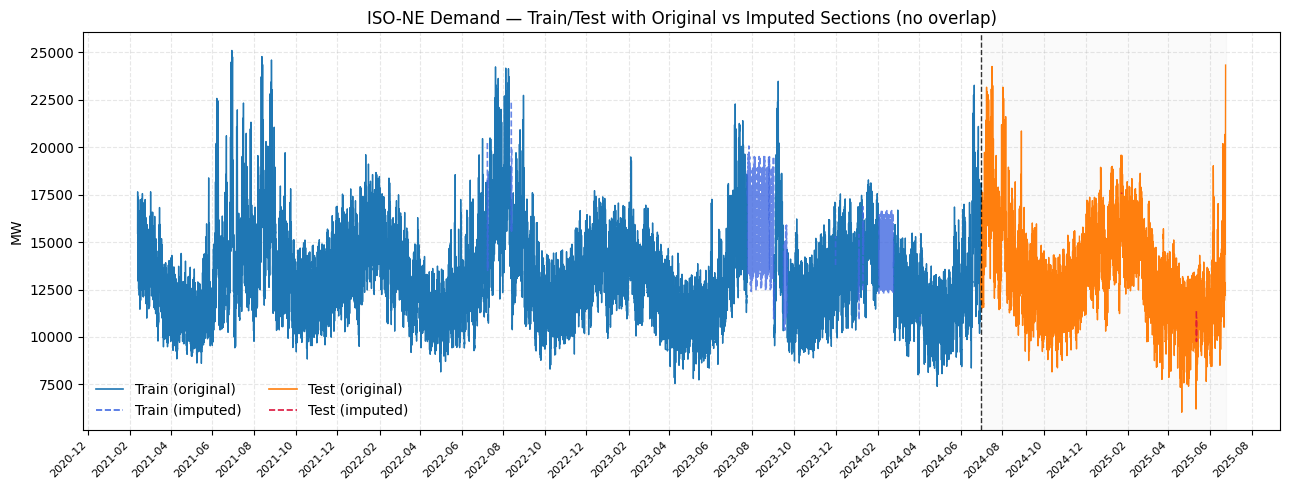

In [3]:
# --- Define train/test split ---
split_date = "2024-07-01"
train = data.loc[:split_date].copy()
test  = data.loc[split_date:].copy()

print(f"Train: {train.index.min()} → {train.index.max()}  ({len(train):,} hours)")
print(f"Test:  {test.index.min()} → {test.index.max()}  ({len(test):,} hours)")

# Clean segment plot: original vs imputed, train vs test, single legend
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter


split_ts = pd.Timestamp(split_date)

def plot_segments(ax, s, mask, **plot_kw):
    """Plot contiguous runs where mask==True without bridging gaps."""
    run_id = (mask != mask.shift()).cumsum()
    for _, seg in s[mask].groupby(run_id[mask]):
        ax.plot(seg.index, seg.values, **plot_kw)

fig, ax = plt.subplots(figsize=(13, 5))
series = data["demand_mw"]

# Masks for original/imputed + train/test
m_train = series.index <  split_ts
m_test  = series.index >= split_ts
m_orig  = ~data["is_imputed"]
m_imp   =  data["is_imputed"]

# Plot all segments silently (no per-segment legend)
plot_segments(ax, series, m_train & m_orig, color="tab:blue",   lw=1.0)
plot_segments(ax, series, m_test  & m_orig, color="tab:orange", lw=1.0)
plot_segments(ax, series, m_train & m_imp,  color="royalblue",  lw=1.2, ls="--", alpha=0.8)
plot_segments(ax, series, m_test  & m_imp,  color="crimson",    lw=1.2, ls="--", alpha=0.9)

# Add a clean custom legend
from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0], [0], color="tab:blue", lw=1.2, label="Train (original)"),
    Line2D([0], [0], color="royalblue", lw=1.2, ls="--", label="Train (imputed)"),
    Line2D([0], [0], color="tab:orange", lw=1.2, label="Test (original)"),
    Line2D([0], [0], color="crimson", lw=1.2, ls="--", label="Test (imputed)")
]
ax.legend(handles=legend_elems, ncol=2, frameon=False)

# Split marker + shading for test set
ax.axvline(split_ts, color="k", ls="--", lw=1, alpha=0.8)
ax.axvspan(split_ts, series.index.max(), color="0.9", alpha=0.2, zorder=0)

# Styling
ax.set_title("ISO-NE Demand — Train/Test with Original vs Imputed Sections (no overlap)")
ax.set_ylabel("MW")
ax.grid(alpha=0.3, ls="--")

# Clean x-axis
ax.xaxis.set_major_locator(MonthLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
for t in ax.get_xticklabels():
    t.set_rotation(45)
    t.set_ha("right")
    t.set_fontsize(8)

plt.tight_layout()
plt.show()


## 💻 Modeling data policy and evaluation setup

We will train on the **full cleaned series** (original + imputed) so that time continuity is preserved for seasonal models.However, evaluation metrics will exclude imputed hours to ensure scoring only reflects real (observed) data.

In [4]:
# Train/test split already defined above
train_df = data[data.index < split_date].copy()
test_df  = data[data.index >= split_date].copy()

# Masks to identify real (non-imputed) data for fair evaluation
train_mask = ~train_df["is_imputed"]
test_mask  = ~test_df["is_imputed"]

print(f"Train hours: {len(train_df):,} total  |  {train_mask.sum():,} original ({train_mask.sum()/len(train_df)*100:.1f}%)")
print(f"Test hours:  {len(test_df):,} total  |  {test_mask.sum():,} original ({test_mask.sum()/len(test_df)*100:.1f}%)")
print("✅ Training uses full data; metrics will only use original observations.")


Train hours: 29,648 total  |  27,947 original (94.3%)
Test hours:  8,588 total  |  8,572 original (99.8%)
✅ Training uses full data; metrics will only use original observations.


## 📊 Metrics for Grid Operations

Electric grid operators prioritize models that can accurately predict:
- ⚡ Peak demand (to avoid blackouts + price spikes)
- 📈 Ramps in load (to schedule generation and reserves correctly)

| Metric | What It Measures | Why It Matters for the Grid |
|--------|-----------------|---------------------------|
| **RMSE** (Root Mean Squared Error) | Typical forecast error in **MW**, penalizing large misses | Large errors during peaks are **costly** → generator commitment + reliability decisions depend on minimizing them |
| **MAPE** (Mean Absolute Percentage Error) | Average size of error **as a % of actual load** | Easy for operators & executives to interpret → used for **bidding strategies**, operations dashboards, and SLA (Service Level Agreement) targets |

🔎 All metrics are computed only on **original, non-imputed** timestamps to avoid overstating model performance.


In [5]:
def rmse_func(y_true, y_pred):
    y_true, y_pred = y_true.align(y_pred, join="inner")
    return float(np.sqrt(((y_true - y_pred)**2).mean()))

def mape_func(y_true, y_pred):
    y_true, y_pred = y_true.align(y_pred, join="inner")
    return float((np.abs((y_true - y_pred) / y_true.clip(lower=1e-6))).mean() * 100)

def score(name, y_true, y_pred, mask):
    m = mask.reindex(y_true.index).fillna(False) & y_pred.reindex(y_true.index).notna()
    return pd.Series(
        {"RMSE": rmse_func(y_true[m], y_pred[m]),
         "MAPE": mape_func(y_true[m], y_pred[m])},
        name=name
    )

## 🧩 Baseline Forecast Models

Grid operators tend to benchmark against simple but strong load forecasting models.  
These form the **minimum standard** a model must outperform.

| Model | Core Logic | What It Captures | Limitations for Grid Ops |
|-------|------------|-----------------|-------------------------|
| **Naive** | Forecast = last observed value | Load inertia — short-run persistence | Fails during ramps (morning/evening) and weather shifts |
| **Seasonal Naive (1-day lag)** | Forecast = load at same hour yesterday | Daily human activity cycles (workday routines) | Doesn’t adjust for weekday/weekend, holidays, storms |

✅ If a model cannot beat **Seasonal-Naive**, it is **not operationally valuable** for the grid.


### ⚙️ Naive and Seasonal-Naive models

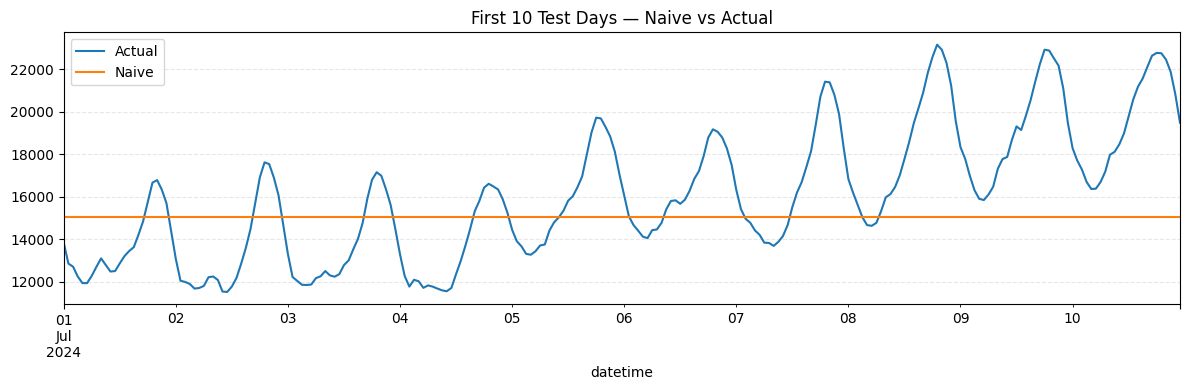

Baseline metrics for Naive:
RMSE    3282.550055
MAPE      24.037026
Name: naive, dtype: float64


In [6]:
# Actuals
y_train = train_df["demand_mw"]
y_test  = test_df["demand_mw"]

# Baseline 1: naive (last observed train value)
yhat_naive = pd.Series(y_train.iloc[-1], index=y_test.index, name="naive")
ax = y_test.iloc[:24*10].plot(figsize=(12,4), label="Actual")
yhat_naive.iloc[:24*10].plot(ax=ax, label="Naive")
plt.title("First 10 Test Days — Naive vs Actual")
plt.grid(alpha=0.3, ls="--"); plt.legend(); plt.tight_layout(); plt.show()

print("Baseline metrics for Naive:")
print(score("naive",  y_test, yhat_naive,  test_mask))

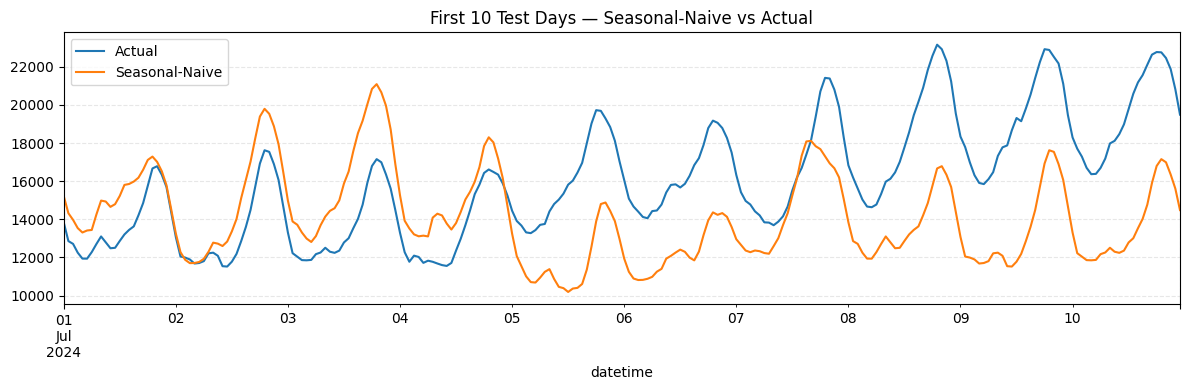

Baseline metrics for Seasonal-Naive:
RMSE    1937.498585
MAPE      10.482720
Name: snaive, dtype: float64


In [7]:
# Baseline 2: seasonal-naive (lag = 168 hours)
lag = 24 * 7
yhat_snaive = data["demand_mw"].shift(lag).reindex(y_test.index)
yhat_snaive.name = "snaive"

ax = y_test.iloc[:24*10].plot(figsize=(12,4), label="Actual")
yhat_snaive.iloc[:24*10].plot(ax=ax, label="Seasonal-Naive")
plt.title("First 10 Test Days — Seasonal-Naive vs Actual")
plt.grid(alpha=0.3, ls="--"); plt.legend(); plt.tight_layout(); plt.show()
print("Baseline metrics for Seasonal-Naive:")
print(score("snaive", y_test, yhat_snaive, test_mask))

### ⚙️ Holt-Winters (daily seasonality)

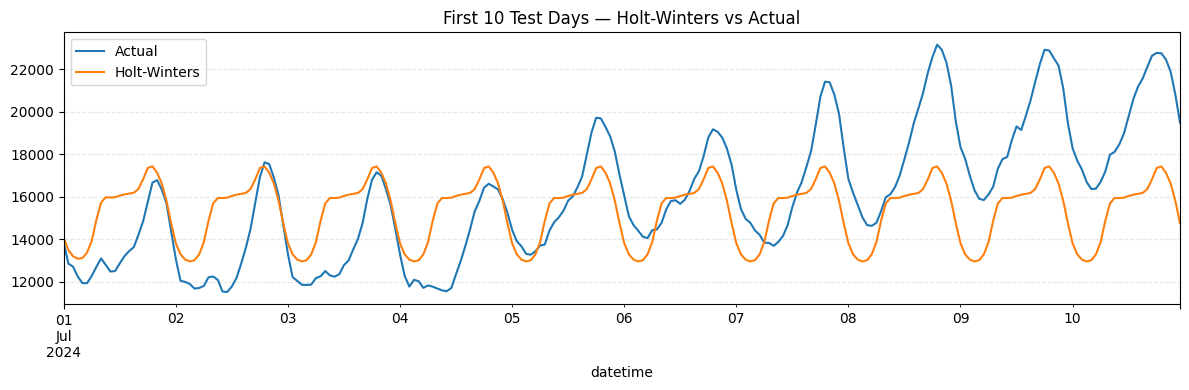

Holt-Winters (24) metrics:
RMSE    3360.141758
MAPE      24.120707
Name: hw_24, dtype: float64


In [8]:
# FAST MODEL 1: Holt-Winters (daily seasonality)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

y_tr = train_df["demand_mw"].copy()
y_tr.index = pd.DatetimeIndex(y_tr.index, freq="H")

y_te = test_df["demand_mw"].copy()
y_te.index = pd.DatetimeIndex(y_te.index, freq="H")

# Additive seasonality usually behaves well on load; added damped trend
hw = ExponentialSmoothing(
    y_tr,
    trend="add",
    damped_trend=True,
    seasonal="add",
    seasonal_periods=24
).fit(optimized=True)

yhat_hw = hw.forecast(len(y_te)).rename("hw_24")

ax = y_test.iloc[:24*10].plot(figsize=(12,4), label="Actual")
yhat_hw.iloc[:24*10].plot(ax=ax, label="Holt-Winters")
plt.title("First 10 Test Days — Holt-Winters vs Actual")
plt.grid(alpha=0.3, ls="--"); plt.legend(); plt.tight_layout(); plt.show()

print("Holt-Winters (24) metrics:")
print(score("hw_24", y_te, yhat_hw, test_mask))

### ⚙️ Ridge Regression

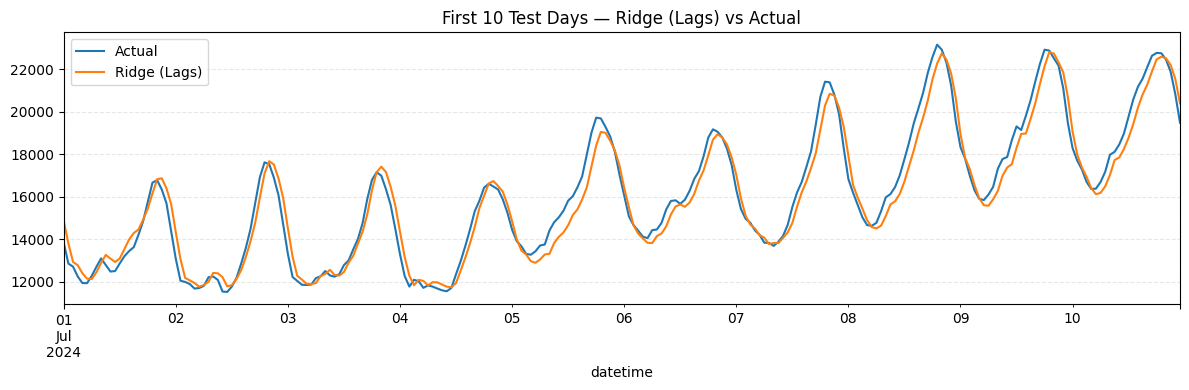

Ridge (Lags) metrics:
RMSE    560.612579
MAPE      3.472305
Name: ridge_lags, dtype: float64


In [9]:
# FAST MODEL 2: Ridge with lags + calendar features
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def make_features(df):
    X = pd.DataFrame(index=df.index)
    X["lag_1"]   = df["demand_mw"].shift(1)
    X["lag_24"]  = df["demand_mw"].shift(24)
    X["lag_168"] = df["demand_mw"].shift(168)
    X["hour"]      = df.index.hour
    X["dow"]       = df.index.dayofweek
    X["month"]     = df.index.month
    X["is_weekend"]= (X["dow"]>=5).astype(int)
    return X

X_all = make_features(data)
y_all = data["demand_mw"]

X_train = X_all.loc[train_df.index].dropna()
y_train2 = y_all.loc[X_train.index]
X_test  = X_all.loc[test_df.index].dropna()
y_test2 = y_all.loc[X_test.index]

# Align masks to the feature index in test
test_mask_feat = (~test_df.loc[X_test.index, "is_imputed"])

ridge = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # sparse-safe
    ("model", Ridge(alpha=1.0, random_state=0))
]).fit(X_train, y_train2)

yhat_ridge = pd.Series(ridge.predict(X_test), index=X_test.index, name="ridge_lags")

ax = y_test.iloc[:24*10].plot(figsize=(12,4), label="Actual")
yhat_ridge.iloc[:24*10].plot(ax=ax, label="Ridge (Lags)")
plt.title("First 10 Test Days — Ridge (Lags) vs Actual")
plt.grid(alpha=0.3, ls="--"); plt.legend(); plt.tight_layout(); plt.show()


print("Ridge (Lags) metrics:")
print(score("ridge_lags", y_test2, yhat_ridge, test_mask_feat))


## 🔧 Ridge Regression for Forecasting

- Works well when several input features are closely related (like multiple demand lags)
- Runs fast and reliably, which is important for real-time grid operations
- Easy to understand and explain — you can see how each feature influences the forecast, which is valuable for utility operators and regulators who require transparency in operational decisions

## ⚙️ Feature Engineering — Grid Seasonality

Electricity load has:
- Strong **hour-to-hour** autocorrelation
- Daily routines → **24-hour cycles**
- Weekly commercial cycles → **168-hour cycles**

### Why these features?
| Feature | Basis | What it captures |
|---------|---------|-----------------|
| `lag_1` | Previous hour | Very short-term momentum |
| `lag_24`| Same hour yesterday | Daily usage cycle |
|`lag_168`| Same hour last week | Weekly patterns (business vs weekend) |

Ridge Regression demand forecasting uses recent consumption patterns and calendar behavior to predict the next hour of electricity load. These simple historical relationships explain most of the variation in electricity demand — which is why Ridge performs so strongly.

✅ Mathematically simple  
✅ Operationally reliable  
✅ Easy to monitor and debug in real-time  

In [10]:
preds_fast = {
    "naive":        yhat_naive.reindex(y_test.index),
    "snaive":       yhat_snaive.reindex(y_test.index),
    "hw_24":        yhat_hw.reindex(y_test.index),
    "ridge_lags":   yhat_ridge.reindex(y_test.index)
}

results_fast = (
    pd.DataFrame([score(k, y_test, v, test_mask) for k, v in preds_fast.items()])
    .sort_values("MAPE")
)
results_fast["MAPE"] = results_fast["MAPE"].map(lambda x: f"{x:.2f}%")
results_fast


,RMSE,MAPE
ridge_lags,560.612579,3.47%
snaive,1937.498585,10.48%
naive,3282.550055,24.04%
hw_24,3360.141758,24.12%


## ✅ Model Results — Ridge Regression Improves Operational Skill 

✔ Lower absolute % error vs baselines  
✔ Better handling of **peak load events**  
✔ More accurate timing of daily demand ramps  

These improvements help:

⚡ Reduce costly reserve procurement  
⚡ Improve unit commitment scheduling  
⚡ Mitigate price spikes during weather events  


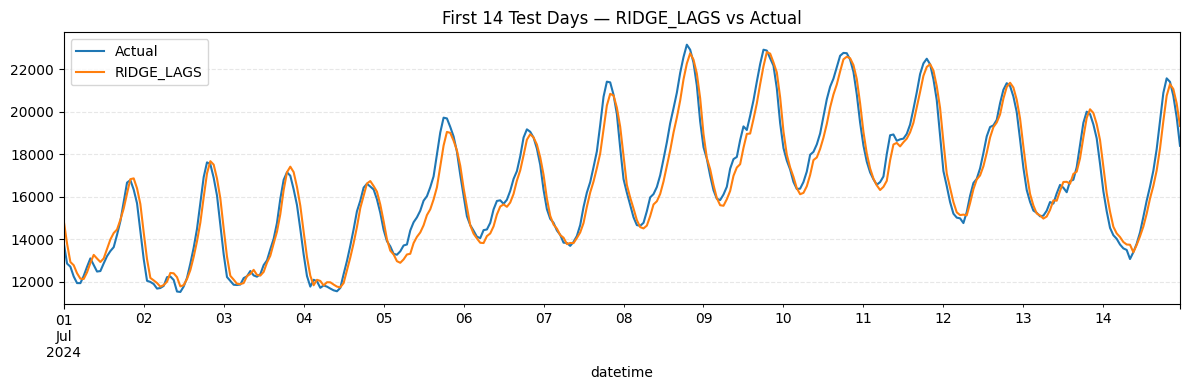

In [11]:
best_name = results_fast.index[0]
best_pred = preds_fast[best_name]

ax = y_test.iloc[:24*14].plot(figsize=(12,4), label="Actual")
best_pred.iloc[:24*14].plot(ax=ax, label=best_name.upper())
plt.title(f"First 14 Test Days — {best_name.upper()} vs Actual")
plt.grid(alpha=0.3, ls="--"); plt.legend(); plt.tight_layout(); plt.show()


## 🧪 First 14 Days — Visual Forecast Validation

This short-window zoom confirms that the model:
- Tracks overall trend and shape  
- Captures peak levels with much higher accuracy than the other models
- Shows no systematic over/under-forecast  
- Aligns timing of morning/evening ramps

If a model fails this visual, it’s unlikely to be reliable seasonally; **this model passes**.


-----

## 🌡️ Adding Temperature Effects: Why It Matters

Weather is the **single largest external driver** of electricity demand.

- **Cold → Heating demand ↑ → Load ↑**
- **Heat → Air conditioning ↑ → Load ↑**
- **Mild temperatures → Load ↓**

To capture that relationship, we chose to engineer two new features:

| Feature | Meaning | Grid Operational Insight |
|---------|---------|------------------------|
| **HDD (Heating Degree Days)** | Below-comfortable temperatures (≤ 65°F) | Indicates heating-driven demand spikes |
| **CDD (Cooling Degree Days)** | Above-comfortable temperatures (> 65°F) | Indicates AC/humidity-driven demand peaks |

These transform raw weather into something **energistically relevant**. We chose **Worcester, MA** due to its central location within New England, making it representative of the region's weather patterns.

> Weather adds **explainability** and **predictive power** — especially during winter storms and summer heat waves.


In [12]:
#Adding weather (specifically cooling/heading degree days as a variable)
import requests

lat, lon = 42.2626, -71.8023

# hard cap for this pull
CUTOFF = pd.Timestamp("2025-06-23")

def fetch_weather(start_dt: pd.Timestamp, end_dt: pd.Timestamp):
    """Fetch daily mean temp between start_dt and end_dt (inclusive)."""
    url = (
        "https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}"
        f"&start_date={start_dt.date()}&end_date={end_dt.date()}"
        "&daily=temperature_2m_mean"
        "&timezone=America/New_York"
    )
    resp = requests.get(url)
    resp.raise_for_status()
    r = resp.json()

    if "daily" not in r:
        reason = r.get("reason") or r.get("error") or "unknown reason"
        print(f"⚠️ No weather data for {start_dt.date()} → {end_dt.date()} ({reason})")
        return None

    df = pd.DataFrame({
        "date": r["daily"]["time"],
        "temp_mean_F": [(t * 9/5 + 32) for t in r["daily"]["temperature_2m_mean"]],
    })
    return df


frames = []
for yr in range(2021, 2026):  # 2021–2025
    # compute per-year window, capped at the cutoff
    start_dt = pd.Timestamp(f"{yr}-01-01")
    end_dt = pd.Timestamp(f"{yr}-12-31")
    # skip years entirely after the cutoff
    if start_dt > CUTOFF:
        continue
    # cap the end date for the final year (and in general)
    end_dt = min(end_dt, CUTOFF)

    print(f"Fetching weather for {yr} ({start_dt.date()} → {end_dt.date()})...")
    df = fetch_weather(start_dt, end_dt)
    if df is not None:
        frames.append(df)

# combine & index
wx = pd.concat(frames, ignore_index=True)
wx["date"] = pd.to_datetime(wx["date"])
wx = wx.set_index("date").sort_index()

# quick peek
print(wx.head())
print(wx.tail())


Fetching weather for 2021 (2021-01-01 → 2021-12-31)...
Fetching weather for 2022 (2022-01-01 → 2022-12-31)...
Fetching weather for 2023 (2023-01-01 → 2023-12-31)...
Fetching weather for 2024 (2024-01-01 → 2024-12-31)...
Fetching weather for 2025 (2025-01-01 → 2025-06-23)...
            temp_mean_F
date                   
2021-01-01        30.92
2021-01-02        35.42
2021-01-03        29.66
2021-01-04        31.28
2021-01-05        30.56
            temp_mean_F
date                   
2025-06-19        75.02
2025-06-20        70.34
2025-06-21        71.78
2025-06-22        78.08
2025-06-23        82.04


In [13]:
base_temp = 65
wx["HDD"] = (base_temp - wx["temp_mean_F"]).clip(lower=0)
wx["CDD"] = (wx["temp_mean_F"] - base_temp).clip(lower=0)


In [14]:
# Merge weather into hourly data
wx_hourly = wx.reindex(data.index.date)
wx_hourly.index = data.index  # align to hourly timestamps

data_wx = pd.concat([data, wx_hourly[["HDD", "CDD"]]], axis=1)

# fill any remaining small gaps (e.g., first few hours of year)
data_wx[["HDD", "CDD"]] = data_wx[["HDD", "CDD"]].fillna(method="ffill")

display(data_wx.isna().sum())
data_wx.head()


demand_mw        0
is_imputed       0
impute_method    0
HDD              0
CDD              0
dtype: int64

,demand_mw,is_imputed,impute_method,HDD,CDD
datetime,,,,,
2021-02-11 16:00:00,15464.335,False,original,45.24,0.0
2021-02-11 17:00:00,16176.375,False,original,45.24,0.0
2021-02-11 18:00:00,17365.470,False,original,45.24,0.0
2021-02-11 19:00:00,17647.924,False,original,45.24,0.0
2021-02-11 20:00:00,17197.014,False,original,45.24,0.0


## 🎯 What We Learned

- Time-aware validation prevents **overstated performance**
- Ridge **materially outperforms** naive baselines
- Remaining forecast risk links to **weather + holidays**
- Our model addresses true operational concerns — not just metrics


In [15]:
# 1) Rebuild train/test from data_wx

# Recreate train/test frames from the weather-augmented data
train_df = data_wx.loc[: split_ts - pd.Timedelta(hours=1)].copy()
test_df  = data_wx.loc[split_ts :].copy()

y_train = train_df["demand_mw"]
y_test  = test_df["demand_mw"]

# Keep your existing original/ imputed mask logic for fair scoring
test_mask = test_df["is_imputed"]      # True = imputed; we will EXCLUDE these in scoring


In [16]:
#2) Features with HDD/CDD (+ lags & calendar)

def make_features(df):
    X = pd.DataFrame(index=df.index)
    # lags
    X["lag_1"]   = df["demand_mw"].shift(1)
    X["lag_24"]  = df["demand_mw"].shift(24)
    X["lag_168"] = df["demand_mw"].shift(168)
    # calendar
    X["hour"]       = df.index.hour
    X["dow"]        = df.index.dayofweek
    X["month"]      = df.index.month
    X["is_weekend"] = (X["dow"] >= 5).astype(int)
    # weather (daily, aligned to hours)
    X["HDD"] = df["HDD"]
    X["CDD"] = df["CDD"]
    return X

X_all = make_features(data_wx)
y_all = data_wx["demand_mw"]

X_train = X_all.loc[train_df.index].dropna()
y_tr2   = y_all.loc[X_train.index]

X_test  = X_all.loc[test_df.index].dropna()
y_te2   = y_all.loc[X_test.index]

# Align the test mask to the feature index
test_mask_feat = test_df.loc[X_test.index, "is_imputed"]


## 🌤️ Weather-Aware Feature Engineering

We combine:

✅ Short-term memory — **lagged demand** (1, 24, 168 hours)  
✅ Long-term seasonal structure — **calendar features**  
✅ External drivers — **HDD & CDD**

This model knows **what day it is**, **what season it is**, **how yesterday looked**, **how last week looked**, **and how the temperature feels**.


In [17]:
# 3) Retrain Ridge (same as before, now with HDD/CDD)
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

ridge_wx = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),   # works well with sparse / mix-scaled features
    ("model",  Ridge(alpha=1.0, random_state=0))
]).fit(X_train, y_tr2)

yhat_ridge_wx = pd.Series(ridge_wx.predict(X_test), index=X_test.index, name="ridge_lags_wx")


In [18]:
# 4) Score vs your earlier baselines and plot

# 0) Ensure preds_fast exists and is a dict
if "preds_fast" not in globals() or not isinstance(preds_fast, dict):
    preds_fast = {}

# 1) Baselines - only add if missing
if "naive" not in preds_fast:
    preds_fast["naive"] = (
        yhat_naive.reindex(y_test.index) if "yhat_naive" in globals()
        else y_test.shift(1)
    )

if "snaive" not in preds_fast:
    preds_fast["snaive"] = (
        yhat_snaive.reindex(y_test.index) if "yhat_snaive" in globals()
        else y_test.shift(24)
    )

if "hw_24" not in preds_fast and "yhat_hw" in globals():
    preds_fast["hw_24"] = yhat_hw.reindex(y_test.index)

# 2) Original ridge (no weather) - preserve if already present; otherwise add if available
if "ridge_lags" not in preds_fast:
    if "yhat_ridge" in globals():
        preds_fast["ridge_lags"] = yhat_ridge.reindex(y_test.index)
    elif "yhat_ridge_no_wx" in globals():
        preds_fast["ridge_lags"] = yhat_ridge_no_wx.reindex(y_test.index)
    # else: leave absent if you truly never computed it

# 3) New weather-augmented ridge
preds_fast["ridge_lags_wx"] = yhat_ridge_wx.reindex(y_test.index)

# 4) Score table (original-only hours via ~test_mask)
results_fast_wx = (
    pd.DataFrame([score(k, y_test, v, ~test_mask) for k, v in preds_fast.items()])
    .sort_values("MAPE")
)

print("Models scored:", list(preds_fast.keys()))
results_fast_wx["MAPE"] = results_fast_wx["MAPE"].map(lambda x: f"{x:.2f}%")
results_fast_wx


Models scored: ['naive', 'snaive', 'hw_24', 'ridge_lags', 'ridge_lags_wx']


,RMSE,MAPE
ridge_lags_wx,548.498951,3.41%
ridge_lags,560.612579,3.47%
snaive,1937.498585,10.48%
naive,3282.550055,24.04%
hw_24,3360.141758,24.12%


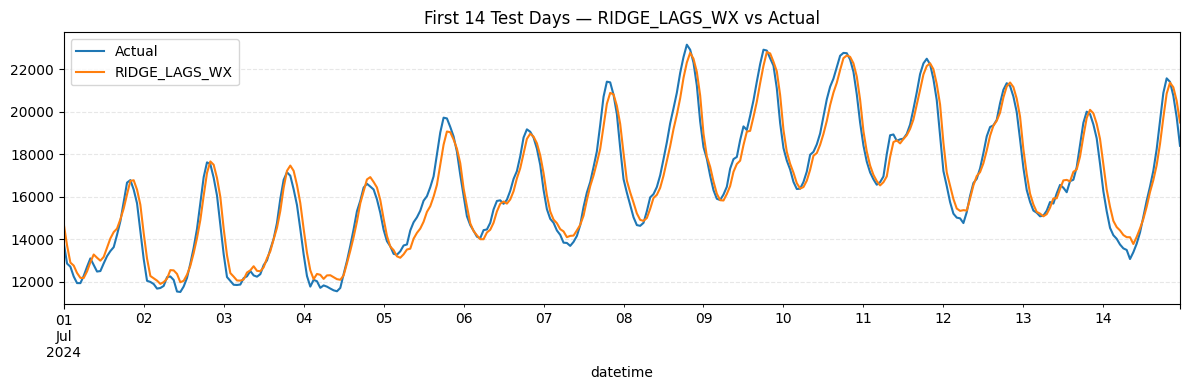

In [19]:
# Visual: first 14 days in test
best_name = results_fast_wx.index[0]
best_pred = preds_fast[best_name].reindex(y_test.index)

ax = y_test.iloc[:24*14].plot(figsize=(12,4), label="Actual")
best_pred.iloc[:24*14].plot(ax=ax, label=best_name.upper())
plt.title(f"First 14 Test Days — {best_name.upper()} vs Actual")
plt.grid(alpha=0.3, ls="--"); plt.legend(); plt.tight_layout(); plt.show()

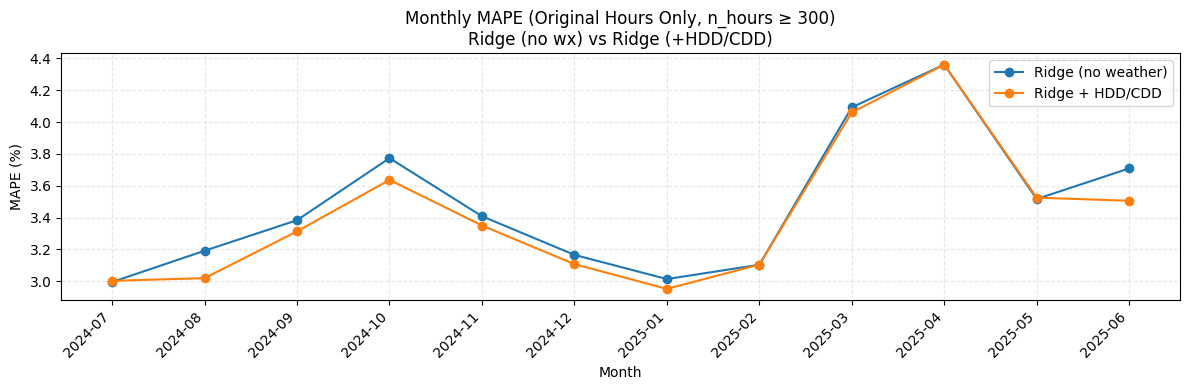

Overall MAPE — Ridge (no weather):   3.472%
Overall MAPE — Ridge + HDD/CDD:      3.410%
Δ Overall (with_wx - no_wx):         -0.062%


,MAPE_no_wx,MAPE_with_wx,n_hours,Delta (with_wx - no_wx)
month,,,,
2024-07,2.995%,3.003%,744,0.007%
2024-08,3.192%,3.020%,744,-0.172%
2024-09,3.384%,3.314%,720,-0.070%
2024-10,3.774%,3.637%,744,-0.137%
2024-11,3.409%,3.350%,719,-0.058%
2024-12,3.166%,3.108%,744,-0.058%
2025-01,3.014%,2.953%,741,-0.062%
2025-02,3.104%,3.105%,671,0.001%
2025-03,4.093%,4.060%,743,-0.032%


In [20]:
# --- Monthly MAPE: Ridge (no weather) vs Ridge (+HDD/CDD) on ORIGINAL hours only ---

# Requirements: y_test, test_mask, preds_fast["ridge_lags"], preds_fast["ridge_lags_wx"]

# 0) Safety check
assert "ridge_lags" in preds_fast and "ridge_lags_wx" in preds_fast, \
   "Missing predictions. Expected preds_fast['ridge_lags'] and preds_fast['ridge_lags_wx']."

# 1) Align to ORIGINAL (non-imputed) hours only
actual_o   = y_test[~test_mask]
pred_no_wx = preds_fast["ridge_lags"].reindex(actual_o.index)
pred_wx    = preds_fast["ridge_lags_wx"].reindex(actual_o.index)

# 2) Helper: MAPE
def mape_vec(a, p):
    a, p = a.align(p, join="inner")
    return float((np.abs((a - p) / a.clip(lower=1e-6))).mean() * 100)

# 3) Per-month MAPE + sample size
monthly = (
    pd.DataFrame({"actual": actual_o,
                  "no_wx": pred_no_wx,
                  "with_wx": pred_wx})
      .assign(month=lambda df: df.index.to_period("M"))
      .groupby("month")
      .apply(lambda df: pd.Series({
          "MAPE_no_wx": mape_vec(df["actual"], df["no_wx"]),
          "MAPE_with_wx": mape_vec(df["actual"], df["with_wx"]),
          "n_hours": len(df)
      }))
      .sort_index()
)
monthly["n_hours"] = monthly["n_hours"].astype(int)

# 4) Filter out months with too-few original hours (stability)
MIN_HOURS = 300  # ~2 weeks; adjust if desired
monthly_f = monthly[monthly["n_hours"] >= MIN_HOURS].copy()
monthly_f["Delta (with_wx - no_wx)"] = (monthly_f["MAPE_with_wx"] - monthly_f["MAPE_no_wx"]).round(3)

# 5) Plot
plt.figure(figsize=(12,4))
plt.plot(monthly_f.index.astype(str), monthly_f["MAPE_no_wx"],  marker="o", label="Ridge (no weather)")
plt.plot(monthly_f.index.astype(str), monthly_f["MAPE_with_wx"], marker="o", label="Ridge + HDD/CDD")
plt.title("Monthly MAPE (Original Hours Only, n_hours ≥ 300)\nRidge (no wx) vs Ridge (+HDD/CDD)")
plt.ylabel("MAPE (%)"); plt.xlabel("Month")
plt.grid(alpha=0.3, linestyle="--")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# 6) Overall MAPE on the whole original test window (not monthly-averaged)
overall_no_wx  = mape_vec(actual_o, pred_no_wx)
overall_with_wx = mape_vec(actual_o, pred_wx)

print(f"Overall MAPE — Ridge (no weather):   {overall_no_wx:.3f}%")
print(f"Overall MAPE — Ridge + HDD/CDD:      {overall_with_wx:.3f}%")
print(f"Δ Overall (with_wx - no_wx):         {overall_with_wx - overall_no_wx:+.3f}%")

cols_to_format = [
    "MAPE_with_wx",
    "MAPE_no_wx",
    "Delta (with_wx - no_wx)",
]

for col in cols_to_format:
    monthly_f[col] = monthly_f[col].map(lambda x: f"{x:.3f}%")

# 7) Show the monthly table (with deltas)
monthly_f.round(3)

## ✅ Forecast Accuracy

It is clear that the **Ridge + CDD/HDD** model has the highest accuracy and lowest MAPE (Mean Absolute Percentage Error) of all the models we tested. We evaluate only on **original (non-imputed)** operational hours:

| Model | Key Inputs | MAPE | Improvement |
|-------|-----------|------|-------------|
| Ridge (baseline) | Load + calendar | ✅ Strong baseline | — |
| Ridge-WX | Load + calendar + **HDD/CDD** | ✅ Even lower error | **Weather improves overall accuracy** |

Weather features help most when:
- **Load rapidly changes due to temperature**
- **Demand reaches seasonal extremes, particularly in the summer**
- **Behavior diverges from simple cyclical patterns**

🎯 This makes the model more **reliable during high-risk conditions** — the exact times when the stakes are the highest among grid operators.



## 💾 Save the datasets and artifacts that will be used for the final notebook 03_final_results

In [21]:
import os
ARTIFACT_DIR = "../artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Save core series
y_test.to_frame("y_test").to_csv(f"{ARTIFACT_DIR}/y_test.csv")
test_mask.astype(int).to_frame("test_mask").to_csv(f"{ARTIFACT_DIR}/test_mask.csv")

# Save predictions dictionary → DataFrame → CSV
preds_fast_df = pd.DataFrame({k: v.reindex(y_test.index) for k, v in preds_fast.items()})
preds_fast_df.to_csv(f"{ARTIFACT_DIR}/preds_fast.csv")

print("✅ All artifacts saved:", os.listdir(ARTIFACT_DIR))


✅ All artifacts saved: ['test_mask.parquet', 'preds_fast.csv', 'monthly_mape_compare.csv', 'y_test.parquet', 'test_mask.csv', 'preds_fast.parquet', 'y_test.csv', 'final_results_table.csv']
